# Книжный сервис

Нужно проанализировать основую информацию о книгах, издательствах, авторах, пользовательских обзорах книг, чтобы можно было на основе аналитики сформулировать ценностное предложение для нового сервиса чтения книг по подписке.

## Структура
1. [Начало](#inception)
1. [SQL](#sql)
1. [Выводы](#conclusions)

---

## Начало
<a name='inception' id='inception'></a>
Перестанем мечтать о том, как сделаем последний проект, и начнём его делать

In [ ]:
!pip install python-dotenv -q

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
# from dotenv import load_dotenv
from os import environ

In [ ]:
load_dotenv()

True

In [3]:
sns.set(
    rc = {
        'figure.figsize': (17, 7),
        'figure.dpi': 80,
        'axes.grid': True,
        'axes.grid.axis': 'x',
        'axes.grid.which': 'both',
        'grid.alpha': .4,
        'xtick.minor.visible': True,
        },
    palette = 'colorblind',
    style = 'ticks'
)

In [4]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    environ.get('USER'),
    environ.get('PASSWORD'),
    environ.get('HOST'),
    environ.get('PORT'),
    environ.get('DB')
    )

engine = create_engine(
    connection_string, 
    connect_args={'sslmode':'require'}
    )

In [5]:
def sql(query):
  return pd.io.sql.read_sql(query, engine)

---

## SQL
<a name='sql' id='sql'></a>
Проанализируем что должны

Для начала посмотрим на список таблиц:

In [6]:
q = """
SELECT * FROM books
"""
sql(q)

,book_id,author_id,title,num_pages,publication_date,publisher_id
0,1,546,'Salem's Lot,594,2005-11-01,93
1,2,465,1 000 Places to See Before You Die,992,2003-05-22,336
2,3,407,13 Little Blue Envelopes (Little Blue Envelope...,322,2010-12-21,135
3,4,82,1491: New Revelations of the Americas Before C...,541,2006-10-10,309
4,5,125,1776,386,2006-07-04,268
...,...,...,...,...,...,...
995,996,571,Wyrd Sisters (Discworld #6; Witches #2),265,2001-02-06,147
996,997,454,Xenocide (Ender's Saga #3),592,1996-07-15,297
997,998,201,Year of Wonders,358,2002-04-30,212
998,999,94,You Suck (A Love Story #2),328,2007-01-16,331


In [ ]:
q = """
SELECT 
    table_name 
FROM 
    information_schema.tables 
WHERE 
    table_schema = 'public'
"""

tables = sql(q)
tables

,table_name
0,advertisment_costs
1,authors
2,books
3,orders
4,publishers
5,ratings
6,reviews
7,visits


Видны странные лишние таблицы (стоит известить администраторов БД)
<br>
Посмотрим теперь на первые строки каждой нужной таблицы:

In [ ]:
for table in (tables['table_name']):
    if table in ('advertisment_costs', 'visits', 'orders'): continue
    
    q = f"""
    SELECT * FROM {table} LIMIT 5
    """
    
    print(table)
    display(sql(q))
    print('-'*100)

authors


,author_id,author
0,1,A.S. Byatt
1,2,Aesop/Laura Harris/Laura Gibbs
2,3,Agatha Christie
3,4,Alan Brennert
4,5,Alan Moore/David Lloyd


----------------------------------------------------------------------------------------------------
books


,book_id,author_id,title,num_pages,publication_date,publisher_id
0,1,546,'Salem's Lot,594,2005-11-01,93
1,2,465,1 000 Places to See Before You Die,992,2003-05-22,336
2,3,407,13 Little Blue Envelopes (Little Blue Envelope...,322,2010-12-21,135
3,4,82,1491: New Revelations of the Americas Before C...,541,2006-10-10,309
4,5,125,1776,386,2006-07-04,268


----------------------------------------------------------------------------------------------------
publishers


,publisher_id,publisher
0,1,Ace
1,2,Ace Book
2,3,Ace Books
3,4,Ace Hardcover
4,5,Addison Wesley Publishing Company


----------------------------------------------------------------------------------------------------
ratings


,rating_id,book_id,username,rating
0,1,1,ryanfranco,4
1,2,1,grantpatricia,2
2,3,1,brandtandrea,5
3,4,2,lorichen,3
4,5,2,mariokeller,2


----------------------------------------------------------------------------------------------------
reviews


,review_id,book_id,username,text
0,1,1,brandtandrea,Mention society tell send professor analysis. ...
1,2,1,ryanfranco,Foot glass pretty audience hit themselves. Amo...
2,3,2,lorichen,Listen treat keep worry. Miss husband tax but ...
3,4,3,johnsonamanda,Finally month interesting blue could nature cu...
4,5,3,scotttamara,Nation purpose heavy give wait song will. List...


----------------------------------------------------------------------------------------------------


Посчитаем, сколько книг вышло в этом тысячелетии:

In [ ]:
q = """
SELECT 
    COUNT(t.book_id) as book_cnt
FROM 
    books t
WHERE 
    date(t.publication_date) >= '2000-01-01'
"""

sql(q)

,book_cnt
0,821


В нашей базе 821 книг, которые вышли в этом веке.
<br>
Посмотрим на количество обзоров и среднюю оценку для каждой книги:

In [ ]:
q = """
SELECT
    b.title,
    COUNT(distinct re.review_id) as review_cnt,
    AVG(ra.rating) as avg_rating
FROM
    books b
LEFT JOIN
    reviews re on b.book_id = re.book_id
LEFT JOIN
    ratings ra on b.book_id = ra.book_id
GROUP BY
    b.book_id
ORDER BY
    review_cnt DESC
"""

temp = sql(q)
temp.head()

,title,review_cnt,avg_rating
0,Twilight (Twilight #1),7,3.662500
1,Water for Elephants,6,3.977273
2,The Glass Castle,6,4.206897
3,Harry Potter and the Prisoner of Azkaban (Harr...,6,4.414634
4,The Curious Incident of the Dog in the Night-Time,6,4.081081


Имеем на текущий момент максимум 7 обзоров для одной книги.

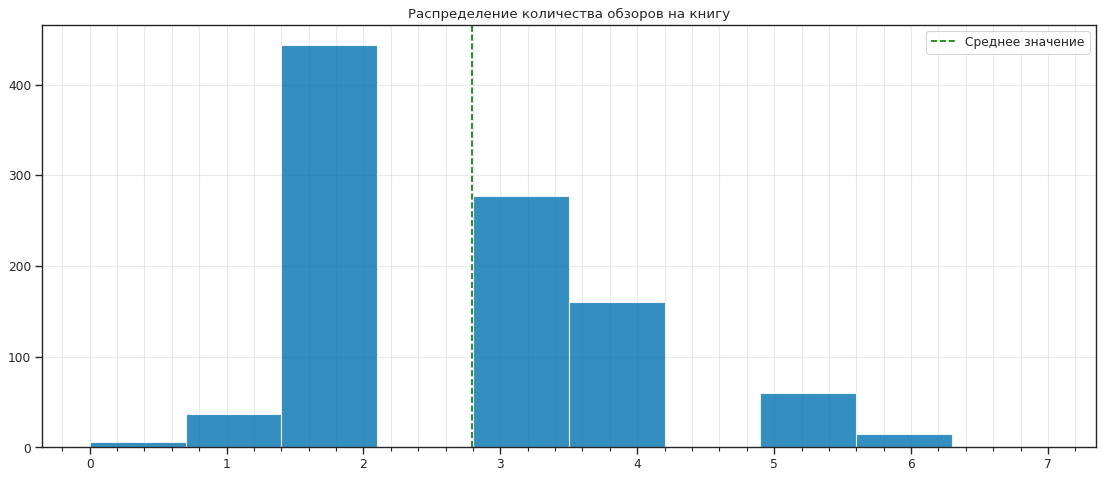

In [ ]:
temp['review_cnt'].hist(alpha=.8)
plt.axvline(temp['review_cnt'].mean(), label='Среднее значение', c='green', ls='--')
plt.title('Распределение количества обзоров на книгу')
plt.legend()
plt.show()

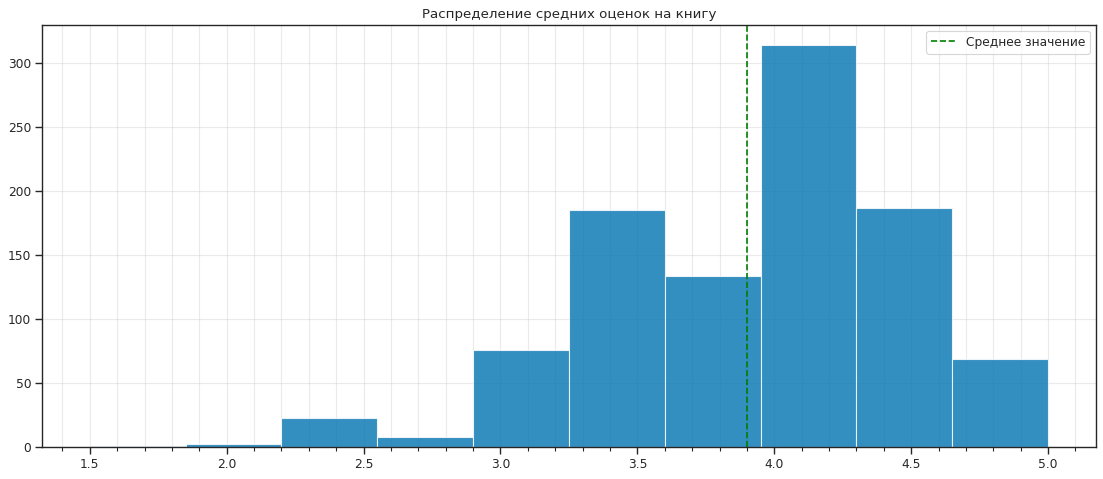

In [ ]:
temp['avg_rating'].hist(alpha=.8)
plt.axvline(temp['avg_rating'].mean(), label='Среднее значение', c='green', ls='--')
plt.title('Распределение средних оценок на книгу')
plt.legend()
plt.show()

Количество рецензий в среднем равно двум-трём, а большинство оценок лежат в диапазоне 4-4.5 баллов.
<br>
Посмотрим на издательства, которые выпустили больше всего книг (от 50 страниц):

In [ ]:
q = """
SELECT
    p.publisher,
    COUNT(b.book_id) as book_cnt
FROM
    books b
LEFT JOIN
    publishers p on b.publisher_id = p.publisher_id
WHERE
    b.num_pages > 50
GROUP BY
    p.publisher
ORDER BY
    book_cnt DESC
"""

temp = sql(q)
temp.head()

,publisher,book_cnt
0,Penguin Books,42
1,Vintage,31
2,Grand Central Publishing,25
3,Penguin Classics,24
4,Ballantine Books,19


Максимум книг у одного издательства - 42.

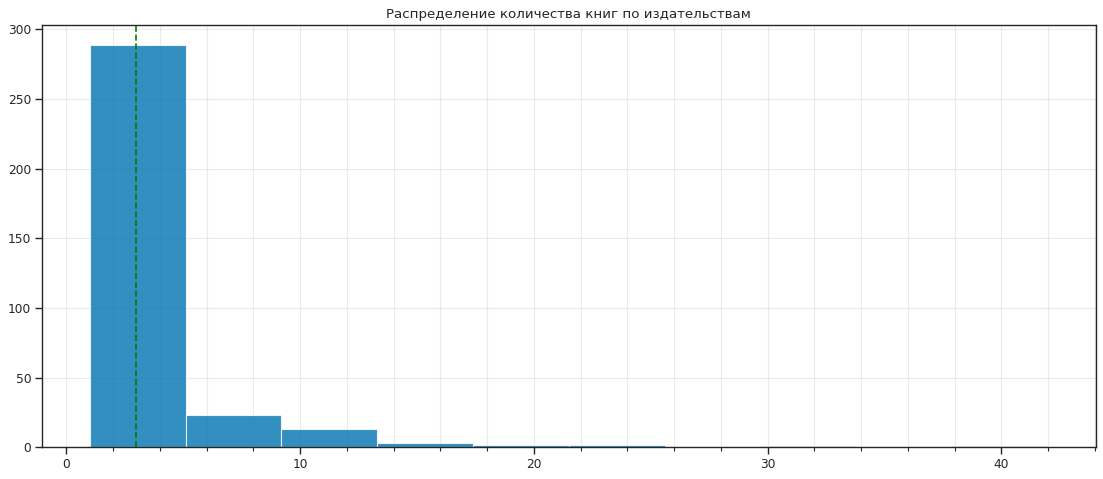

In [ ]:
temp['book_cnt'].hist(alpha=.8)
plt.axvline(temp['book_cnt'].mean(), ls='--', c='green')
plt.title('Распределение количества книг по издательствам')
plt.show()

Но большинство издательств выпустили меньше 5 книг.
<br>
Посмотрим на авторов с самыми высокими оценками популярных книг (от 50 оценок):

In [ ]:
q = """
SELECT
    subq.author,
    AVG(subq.avg_rating) as avg_rating
FROM
    (
        SELECT
            a.author,
            b.book_id,
            AVG(r.rating) as avg_rating
        FROM
            authors a
        LEFT JOIN 
            books b on a.author_id = b.author_id
        LEFT JOIN
            ratings r on b.book_id = r.book_id
        GROUP BY
            a.author,
            b.book_id
        HAVING
            COUNT(rating) > 50
    ) subq
GROUP BY
    subq.author
ORDER BY
    avg_rating DESC
"""

sql(q)

,author,avg_rating
0,J.K. Rowling/Mary GrandPré,4.283844
1,Markus Zusak/Cao Xuân Việt Khương,4.264151
2,J.R.R. Tolkien,4.258446
3,Louisa May Alcott,4.192308
4,Rick Riordan,4.080645
5,William Golding,3.901408
6,J.D. Salinger,3.825581
7,Paulo Coelho/Alan R. Clarke/Özdemir İnce,3.789474
8,William Shakespeare/Paul Werstine/Barbara A. M...,3.787879
9,Dan Brown,3.754540


Имеем всего 14 авторов, у которых есть книги с более чем 50 оценками. Самый рейтинговый автор - Дж.К.Роулинг.
<br>
Посмотрим, как часто активные люди (от 50 оценок) пишут отзывы:

In [ ]:
q = """
SELECT
    AVG(subq.review_cnt) as avg_review_cnt
FROM
    (
        SELECT
            COUNT(re.review_id) as review_cnt
        FROM
            reviews re
        WHERE
            username in (
                SELECT
                    ra.username 
                FROM
                    ratings ra
                GROUP BY
                    ra.username
                HAVING
                    COUNT(ra.rating) > 50
            )
        GROUP BY
            re.username
    ) as subq
"""

sql(q)

,avg_review_cnt
0,24.333333


Среднее число отзывов от активных пользователей - 24.

---

## Выводы
<a name='conclusions' id='conclusions'></a>
Подведём итоги

Проведя анализ имеющихся данных, можно сделать следующие выводы:
- после 1 января 2000 года вышло 821 книг
- Самое большое количество обзоров у книги *Twilling #1* (7). Среднее количество обзоров - чуть меньше трёх
- Больше всего книг выпустило издательство *Penguin Books* (42 книги)
- Самую высокую среднюю оценку за популярные книги имеет *Дж.К.Роулинг* - 4.28
- Среднее количество от активных пользователей - 24.3

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=73c6fdc9-2380-4d92-b495-95da9dd36eb1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>